## Can GPT4 Solve the ARC Challenge?
This notebook was created by John Tan Chong Min on 17 Apr 2023.
- Seek to use GPT4 via zero-shot prompt engineering to generate an output
- Fine-tuning the prompt to let GPT4 ground its answer has proven effective
- Works quite well for grids with small sizes
- Can be better if we ask GPT4 to generate the python code for its description, and use it to check validity based on input/output pairs.
- Can be even better if we have GPT4s with different biases and grounding, and increase diversity of possible generated code

In [4]:
import json

!pip install numpy matplotlib 


import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import copy

def load_json_data(folder):
    json_files = [pos_json for pos_json in os.listdir(folder) if pos_json.endswith('.json')]
    data = {}
    for js in json_files:
        with open(os.path.join(folder, js)) as json_file:
            data[js] = json.load(json_file)
    return data

def plot_2d_grid(data):
    cvals  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    colors = ["black", "dodgerblue", "red", "lightgreen", "yellow", "grey", "magenta", "orange", "lightblue", "brown"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

    fig, axs = plt.subplots(1, 3, figsize=(5, len(data['test']) * 3))
    print(axs.shape)
    axs[0].set_title('Test Input')
    axs[0].set_xticks([]); axs[0].set_yticks([])
    axs[0].imshow(np.array(data['test'][0]['input']), cmap=cmap, vmin=0, vmax=9)
    axs[1].set_title('Test Output')
    axs[1].set_xticks([]); axs[1].set_yticks([])
    axs[1].imshow(np.array(data['test'][0]['output']), cmap=cmap, vmin=0, vmax=9)
    # plot gpt output if present
    if data['gpt_output'] is not None:
        axs[2].set_title('GPT Output')
        axs[2].set_xticks([]); axs[2].set_yticks([])
        axs[2].imshow(np.array(data['gpt_output']), cmap=cmap, vmin=0, vmax=9) 
    else:
        axs[2].axis('off')

    fig, axs = plt.subplots(len(data['train']), 2, figsize=(5, len(data['train']) * 3))
    for i, example in enumerate(data['train']):
        axs[i, 0].set_title(f'Training Input {i}')
        axs[i, 0].set_xticks([]); axs[i, 0].set_yticks([])
        axs[i, 0].imshow(np.array(example['input']), cmap=cmap, vmin=0, vmax=9)
        axs[i, 1].set_title(f'Training Output {i}')
        axs[i, 1].set_xticks([]); axs[i, 1].set_yticks([])
        axs[i, 1].imshow(np.array(example['output']), cmap=cmap, vmin=0, vmax=9)
    plt.tight_layout()
    plt.show()

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/d6/a8/6a2419c40c7b6f7cb4ef52c532c88e55490c4fa92885964757d507adddce/numpy-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.6 MB/s eta 0:00:00
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/32/ad/58902b481f5a294101a53ed964d68a2c2355d55622a8e9cb09fc3f517385/matplotlib-3.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/67/0f/6e5b4879594cd1cbb6a2754d9230937be444f404cf07c360c07a10b36aac/contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-no

## Load the JSON files

- Download from https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip

In [1]:
!wget https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip 
!unzip ARC-800-tasks.zip -d ./ARC-800-tasks

--2024-07-15 03:27:12--  https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip
Resolving lab42.global (lab42.global)... 2606:4700:3033::6815:264c, 2606:4700:3035::ac43:dc15, 172.67.220.21, ...
Connecting to lab42.global (lab42.global)|2606:4700:3033::6815:264c|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418121 (408K) [application/zip]
Saving to: ‘ARC-800-tasks.zip.1’

ARC-800-tasks.zip.1 100%[===================>] 408.32K  --.-KB/s    in 0.06s   

2024-07-15 03:27:12 (6.64 MB/s) - ‘ARC-800-tasks.zip.1’ saved [418121/418121]

Archive:  ARC-800-tasks.zip
replace ./ARC-800-tasks/evaluation/00576224.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
# load the json files

# download the data from 
folder = 'ARC-800-tasks/evaluation'
myjson = load_json_data(folder)

## Get the JSON for the GPT input

In [6]:
task_name = '68b67ca3'
json_task = copy.deepcopy(myjson[task_name +'.json'])

preamble = '''You are given a series of inputs and output pairs. These are all in the form of a 2D grid, with values from 0-9. Each of the input-output relation has a pattern, which could be something like (not exhaustive):
- object view(defined as continuous squares connected horizontally, vertically and/or diagonally)
> ordering by attribute such as number, position, size
> rotating objects
> shifting objects
> changing value of object

- overall view
> rotation / reflection symmetry
> continuation of a pattern
> changing values

- segment view
> combine two segments of the input into one single one according to some rule

The input comes in the form of a 2D array and appears after "input". The output comes in the form of a 2D array and appears after "output". View the input as not just numbers, but an actual 2D grid from which you can group into objects and regions. 

Do the following:
- What is the broad description of the input/output relation?
- What is the detailed description of the input/output and verify that it holds for all input/output pairs?
- Thereafter, write out the answer 'to_be_filled'.'''

# ensure only one test output
json_task['test'] = json_task['test'][0]
json_task['test']['output'] = 'to_be_filled'

print(preamble + '\n\n' + str(json_task))

You are given a series of inputs and output pairs. These are all in the form of a 2D grid, with values from 0-9. Each of the input-output relation has a pattern, which could be something like (not exhaustive):
- object view(defined as continuous squares connected horizontally, vertically and/or diagonally)
> ordering by attribute such as number, position, size
> rotating objects
> shifting objects
> changing value of object

- overall view
> rotation / reflection symmetry
> continuation of a pattern
> changing values

- segment view
> combine two segments of the input into one single one according to some rule

The input comes in the form of a 2D array and appears after "input". The output comes in the form of a 2D array and appears after "output". View the input as not just numbers, but an actual 2D grid from which you can group into objects and regions. 

Do the following:
- What is the broad description of the input/output relation?
- What is the detailed description of the input/ou

# Dispaly the GPT output

(3,)


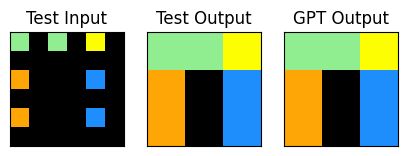

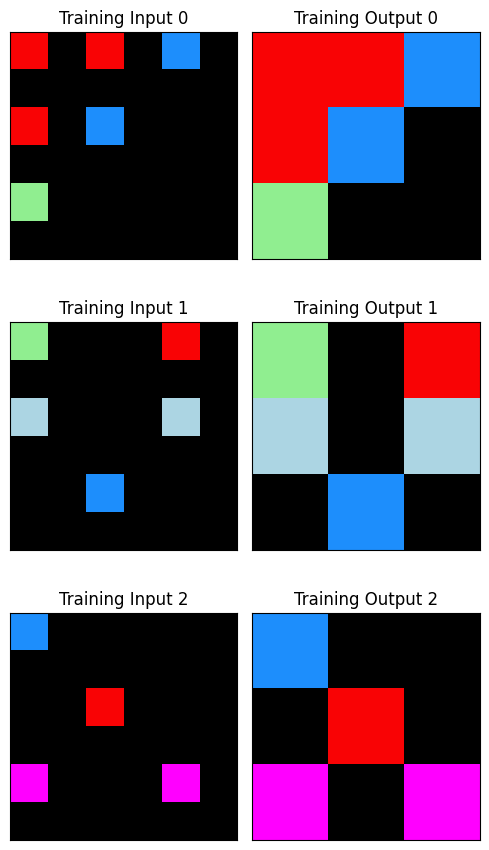

In [7]:
json_task = copy.deepcopy(myjson[task_name +'.json'])

# Add GPT output here (if any)
json_task['gpt_output'] = [
[3, 3, 4],
[7, 0, 1],
[7, 0, 1]]

# json_task['gpt_output'] = None

plot_2d_grid(json_task)

In [102]:
def try_arc_riddle(examples, eval):
    # Import necessary libraries
    import os
    import openai
    import time

    # Set up the OpenAI API key
    openai.api_key = os.getenv("OPENAI_API_KEY")
    client = openai.OpenAI()

    # Function to call OpenAI API
    def call_openai_api(prompt0, model="gpt-4", max_tokens=50, temperature=0.7):
        prompt = f"Pair format: LHS-RHS (LHS numbers are always 0-4)\n{prompt0}"
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        print(prompt)

        response = client.chat.completions.with_raw_response.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens,
            temperature=temperature
        )
        parsed_response = response.parse().choices[0].message.content.strip()
        print("<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>")
        print(parsed_response)
        print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
        return parsed_response

    # Define the SystemState class
    class SystemState:
        def __init__(self, orig_training_pairs, non_training_pairs):
            self.orig_training_pairs = orig_training_pairs
            self.non_training_pairs = non_training_pairs
            self.generated_pairs = []
            self.valid_pairs = []

    # Function to generate new pairs using GPT
    def generate_new_pairs(system_state, starters):      
        starters = set(starters + system_state.orig_training_pairs)
        examples_str = "\n".join(list(starters))
        prompt = f"Generate a new example from:\n{examples_str}\n"
        pair = call_openai_api(prompt, max_tokens=600, temperature=0.3)
        if check_consistency(pair, starters): 
            system_state.generated_pairs.append(pair)  # Add the new pair to the list
            return True
        return False

    # Function to check consistency of a pair using GPT
    def check_consistency(pair, training):
        training = set(training)
        if pair in training: training.remove(pair)
        input_data, output_data = pair.split("-")
        examples_str = "\n".join(training)
        prompt = f"Using the following examples:\n{examples_str}\nGuess the RHS of\n{input_data}-RHS."
        response = call_openai_api(prompt, model="gpt-4", max_tokens=40, temperature=0)
        tf = response.lower().strip().startswith(output_data)
        print("Result: " , tf)
        return tf

    # Function to test original training pairs
    def test_orig_training_pairs(orig_training_pairs, generated_pairs):
        for pair in orig_training_pairs:
            if not check_consistency(pair, generated_pairs):  # Validate the pair implicitly
                return False  # If any pair is not correctly validated, return False
        return True  # Return True if all pairs are validated

    # Initial setup
    orig_training_pairs = examples['orig_training_pairs']
    non_training_pairs = examples['non_training_pairs']

    # Create the system state object
    system_state = SystemState(orig_training_pairs, non_training_pairs)

    # Populate generated_pairs using orig_training_pairs
    generate_new_pairs(system_state, orig_training_pairs)
    generate_new_pairs(system_state, orig_training_pairs)
    generate_new_pairs(system_state, orig_training_pairs)

    # Main process
    tries = 0
    max_tries = 16
    start_time = time.time()
    max_duration = 40  # maximum duration in seconds

    # Continue the process until success or limits are reached
    while tries < max_tries and (time.time() - start_time) < max_duration:
        tries += 1  # Increment tries
        print(f"\nTrial {tries}:")
        if not generate_new_pairs(system_state, system_state.generated_pairs):
            continue
        if test_orig_training_pairs(system_state.orig_training_pairs, system_state.generated_pairs):
            break  # Exit loop if successful

    # Finalize training pairs
    finalRes = test_orig_training_pairs(system_state.non_training_pairs, set(system_state.generated_pairs + system_state.orig_training_pairs))

    # Output or use final_training_pairs as needed
    final_training_pairs = set(system_state.generated_pairs + system_state.orig_training_pairs)
    print(final_training_pairs)

    # Print elapsed time and number of tries
    elapsed_time = time.time() - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print(f"Number of Tries: {tries}")
    print(f"Final Pass: {finalRes}")


# Example usage
examples = {
    "orig_training_pairs": [
        "1144|2324|2323-2288|4648|4646",
        "1122|2344|3444-2244|4688|6888"
    ],
    "non_training_pairs": [
        "3333|1234|2344-6666|2468|4688"
    ]
}

eval = {}  # Placeholder for evaluation parameters if any

try_arc_riddle(examples, eval)



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Pair format: LHS-RHS (LHS numbers are always 0-4)
Generate a new example from:
1144|2324|2323-2288|4648|4646
1122|2344|3444-2244|4688|6888

<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>
1133|2334|3443-2266|4668|6886
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Pair format: LHS-RHS (LHS numbers are always 0-4)
Using the following examples:
1144|2324|2323-2288|4648|4646
1122|2344|3444-2244|4688|6888
Guess the RHS of
1133|2334|3443-RHS.
<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>
2266|4668|6886
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Result:  True
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Pair format: LHS-RHS (LHS numbers are always 0-4)
Generate a new example from:
1144|2324|2323-2288|4648|4646
1122|2344|3444-2244|4688|6888

<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>
1133|2334|3443-2266|4668|6886
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Pair format: LHS-RHS (LHS numbers are always 0-4)
Using the following examples:
1144|2324|2323-2288|4648|4646
1